In [2]:
import re
import string
import itertools
from nltk import bigrams #pay attention to the 's' of bigrams
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
import numpy as np
import csv
import json
import nltk
import operator
from collections import Counter
import gensim
from gensim import corpora
from os import listdir
from os.path import isfile,join
import nltk


# read from files as dataframe
def read_as_df(folder,filename):
    filename=filename.split('.')[0]
    filepath=folder+filename+'.txt'
    df = pd.read_csv(filepath, delimiter="^", header=None,error_bad_lines=False,engine='python')
    df.columns = ["tweets", "time", "date"]
    df['account']=filename 
    return df


# read from files as list 
def read_as_list(filepath):
    with open(filepath) as txt_file:
        lines = txt_file.readlines()
        e_list = []
        for line in lines:
            e_list.append(line)  # store the text into a list # 27608
        return e_list

# drop repetitive words
def strip_drop_duplicated(input_list):
    tem_list=[tweet.strip() for tweet in input_list] #drop the space at the beginning and in the end
    tem_list=list(set(tem_list)) # drop the duplicated # 25600
    return tem_list

# remove all the symbols and non-english words
def remove_symbols(input_list):
    #format:[[],[],[]]
    regex_str = [
        #emoticons_str,
        #r'<[^>]+>',  # HTML tags
        #r'(?:@[\w_]+)',  # @-mentions
        #r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",  # hash-tags
        #r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',  # URLs
        #r'(?:(?:\d+,?)+(?:\.?\d+)?)',  # numbers
        #r"(?:[a-z][a-z'\-_]+[a-z])",  # words with - and '
        #r'(?:[\w_]+)',  # other words
        #r'(?:\S)'  # anything else
    ]

    punctuation=set(string.punctuation)


    POS_f_list=[]

    for tweet in input_list:
        #print(tweet)
        tokens=tweet.split(' ')
        #tokens=tokens_re.findall(tweet)  # tokens is a list   # token is word
        tokens = [ token.lower() for token in tokens]
        tokens = [ re.sub(r'<[^>]+>','',token) for token in tokens]
        tokens = [ re.sub(r'(?:@[\w_]+)','',token) for token in tokens]
        #tokens = [ re.sub(r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",'',token) for token in tokens]
        tokens = [ re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+','',token) for token in tokens]
        tokens = [ re.sub(r'(?:(?:\d+,?)+(?:\.?\d+)?)','',token) for token in tokens]
        tokens = [ re.sub(r'[!?+]','',token) for token in tokens]
        tokens = [ re.sub(r'\&[\w]+[;]?','',token) for token in tokens]
        tokens = [ re.sub(r'[\w]+[.]+[\w]+','',token) for token in tokens]
        tokens = ['' if token in punctuation else token for token in tokens]
        tokens = ['' if len(token)==1 else token for token in tokens]


        result=[]
        for text in tokens:
            try:
                word=re.search(r"(?:^[a-z]+[a-z'\-_]?[a-z]+)",text).group(0)
                result.append(word)
            except:
                pass

        tokens = nltk.pos_tag(result)
        tokens= [words[0] for words in tokens if words[1] in ['NN','NNS','NNP','NNPS']]
        POS_f_list.append(tokens)
        #remove the '' after the replace of symbols in words
        #for i in range(tokens.count('')):
            #tokens.remove('')
        #token_list.append(result)

    #get rid of all the [] in tweets
    new_tweets_list=[]
    for i in POS_f_list:
        if i==[]:
            pass
        else:
            new_tweets_list.append(i)
            #print(i)
    return new_tweets_list


# make some words like 'gooood' to 'good'
def standardize(input_list):
    standardize_tweet_list=[]
    for tweet in input_list:
        standardize_tweet=[''.join(''.join(s)[:2] for _, s in itertools.groupby(word)) for word in tweet]
        standardize_tweet_list.append(standardize_tweet)
    return standardize_tweet_list

# list from: Twitter-LDA/data/stoplist.txt & Twitter-LDA/src/Common/Stopwords.java
# remove stop words
def stop_word_removal(input_list):
    nonstopwd_tweets_list=[]
    swords_mlist=['ah',
'da',
'de',
'di',
'eh',
'ga',
'ha',
'je',
'ke',
'la',
'le',
'lo',
'lu',
'ma',
'ni',
'tu',
'uh',
'wa',
'xx',
'ya',
'dah',
'hah',
'heh',
'lah',
'leh',
'wah',
'wat',
'wow',
'yay',
'zzz',
"a",
"able",
"about",
"above",
"according",
"accordingly",
"across",
"actually",
"after",
"afterwards",
"again",
"against",
"all",
"allow",
"allows",
"almost",
"alone",
"along",
"already",
"also",
"although",
"always",
"am",
"among",
"amongst",
"amp",
"an",
"and",
"another",
"any",
"anybody",
"anyhow",
"anyone",
"anything",
"anyway",
"anyways",
"anywhere",
"apart",
"appear",
"appreciate",
"appropriate",
"are",
"around",
"as",
"aside",
"ask",
"asking",
"associated",
"at",
"available",
"away",
"awfully",
"b",
"be",
"became",
"because",
"become",
"becomes",
"becoming",
"been",
"before",
"beforehand",
"behind",
"being",
"believe",
"below",
"beside",
"besides",
"best",
"better",
"between",
"beyond",
"both",
"brief",
"but",
"by",
"c",
"came",
"can",
"cannot",
"cant",
"cause",
"causes",
"certain",
"certainly",
"changes",
"clearly",
"co",
"com",
"come",
"comes",
"concerning",
"consequently",
"consider",
"considering",
"contain",
"containing",
"contains",
"corresponding",
"could",
"course",
"currently",
"d",
"definitely",
"described",
"despite",
"did",
"different",
"do",
"does",
"doing",
"done",
"down",
"downwards",
"during",
"e",
"each",
"edu",
"eg",
"eight",
"either",
"else",
"elsewhere",
"enough",
"entirely",
"especially",
"et",
"etc",
"even",
"ever",
"every",
"everybody",
"everyone",
"everything",
"everywhere",
"ex",
"exactly",
"example",
"except",
"f",
"far",
"few",
"fifth",
"first",
"five",
"followed",
"following",
"follows",
"for",
"former",
"formerly",
"forth",
"four",
"from",
"further",
"furthermore",
"g",
"get",
"gets",
"getting",
"given",
"gives",
"go",
"goes",
"going",
"gone",
"got",
"gotten",
"greetings",
"h",
"had",
"happens",
"hardly",
"has",
"have",
"having",
"he",
"hello",
"help",
"hence",
"her",
"here",
"hereafter",
"hereby",
"herein",
"hereupon",
"hers",
"herself",
"hi",
"him",
"himself",
"his",
"hither",
"hopefully",
"how",
"howbeit",
"however",
"i",
"ie",
"if",
"ignored",
"immediate",
"in",
"inasmuch",
"inc",
"indeed",
"indicate",
"indicated",
"indicates",
"inner",
"insofar",
"instead",
"into",
"inward",
"is",
"it",
"its",
"itself",
"j",
"just",
"k",
"keep",
"keeps",
"kept",
"know",
"knows",
"known",
"l",
"last",
"lately",
"later",
"latter",
"latterly",
"least",
"less",
"lest",
"let",
"like",
"liked",
"likely",
"little",
"ll",
"look",
"looking",
"looks",
"ltd",
"m",
"mainly",
"many",
"may",
"maybe",
"me",
"mean",
"meanwhile",
"merely",
"might",
"more",
"moreover",
"most",
"mostly",
"much",
"must",
"my",
"myself",
"n",
"name",
"namely",
"nd",
"near",
"nearly",
"necessary",
"need",
"needs",
"neither",
"never",
"nevertheless",
"new",
"next",
"nine",
"no",
"nobody",
"non",
"none",
"noone",
"nor",
"normally",
"not",
"nothing",
"novel",
"now",
"nowhere",
"o",
"obviously",
"of",
"off",
"often",
"oh",
"ok",
"okay",
"old",
"on",
"once",
"one",
"ones",
"only",
"onto",
"or",
"other",
"others",
"otherwise",
"ought",
"our",
"ours",
"ourselves",
"out",
"outside",
"over",
"overall",
"own",
"p",
"particular",
"particularly",
"per",
"perhaps",
"placed",
"please",
"plus",
"possible",
"presumably",
"probably",
"provides",
"q",
"que",
"quite",
"qv",
"r",
"rather",
"rd",
"re",
"really",
"reasonably",
"regarding",
"regardless",
"regards",
"relatively",
"respectively",
"right",
"s",
"said",
"same",
"saw",
"say",
"saying",
"says",
"second",
"secondly",
"see",
"seeing",
"seem",
"seemed",
"seeming",
"seems",
"seen",
"self",
"selves",
"sensible",
"sent",
"serious",
"seriously",
"seven",
"several",
"shall",
"she",
"should",
"since",
"six",
"so",
"some",
"somebody",
"somehow",
"someone",
"something",
"sometime",
"sometimes",
"somewhat",
"somewhere",
"soon",
"sorry",
"specified",
"specify",
"specifying",
"still",
"sub",
"such",
"sup",
"sure",
"t",
"take",
"taken",
"tell",
"tends",
"th",
"than",
"thank",
"thanks",
"thanx",
"that",
"thats",
"the",
"their",
"theirs",
"them",
"themselves",
"then",
"thence",
"there",
"thereafter",
"thereby",
"therefore",
"therein",
"theres",
"thereupon",
"these",
"they",
"think",
"third",
"this",
"thorough",
"thoroughly",
"those",
"though",
"three",
"through",
"throughout",
"thru",
"thus",
"to",
"together",
"too",
"took",
"toward",
"towards",
"tried",
"tries",
"truly",
"try",
"trying",
"twice",
"two",
"u",
"un",
"under",
"unfortunately",
"unless",
"unlikely",
"until",
"unto",
"up",
"upon",
"us",
"use",
"used",
"useful",
"uses",
"using",
"usually",
"uucp",
"v",
"value",
"various",
"ve",
"very",
"via",
"viz",
"vs",
"w",
"want",
"wants",
"was",
"way",
"we",
"welcome",
"well",
"went",
"were",
"what",
"whatever",
"when",
"whence",
"whenever",
"where",
"whereafter",
"whereas",
"whereby",
"wherein",
"whereupon",
"wherever",
"whether",
"which",
"while",
"whither",
"who",
"whoever",
"whole",
"whom",
"whose",
"why",
"will",
"willing",
"wish",
"with",
"within",
"without",
"wonder",
"would",
"would",
"x",
"y",
"yes",
"yet",
"you",
"your",
"yours",
"yourself",
"yourselves",
"z",
"zero",
"i'm",
"he's",
"she's",
"you're",
"i'll",
"you'll",
"she'll",
"he'll",
"it's",
"don't",
"can't",
"didn't",
"i've",
"that's",
"there's",
"isn't",
"what's",
"rt",
"doesn't",
"w/",
"w/o",
"#pb#po",
"#pb#re",
"#pb#rt",
"#pb#me"                     
]
    for tweet in input_list:
        nonstopwd_tweets=[word for word in tweet if word not in (stopwords.words('english'))]
        nonstopwd_tweets=[word for word in tweet if word not in swords_mlist]
        nonstopwd_tweets_list.append(nonstopwd_tweets)
    return nonstopwd_tweets_list

# lematize the word from worked to work
def lematization(input_list):
    lemma_tweets_list=[]
    lemma = WordNetLemmatizer()
    for tweet in input_list:
        lemma_tweet=[lemma.lemmatize(word) for word in tweet]
        lemma_tweets_list.append(lemma_tweet)
    return lemma_tweets_list

# count the word frequency
def term_frequency(text):
    count_all = Counter()
    final_list = []
    for tweet in text:
        for word in tweet:
            final_list.append(word)
    count_all.update(final_list)
    return count_all
        
def list_to_string(input_list):
    result_list=[]
    for tweet in input_list:
        line=' '.join(tweet)
        result_list.append(line)
    return result_list

In [3]:
#positive dataframe
samsungsg_df=read_as_df('/Users/yyb/Documents/5920_Projects/New_data_collection_0312/Positive/','SamsungSG')
samsungsg_df=samsungsg_df.dropna().reset_index(drop=True)

#negative dataframe
negative_folder_path='/Users/yyb/Documents/5920_Projects/New_data_collection_0312/Negative/'
negative_filenames=[f for f in listdir(negative_folder_path) if isfile(join(negative_folder_path,f))]
try:
    negative_filenames.remove('.DS_Store')
    negative_filenames.remove('negative_v1.txt') # the final combine file, have only one column
except:
    pass

for name in negative_filenames:
    name=name.split('.')[0]
    N_df=read_as_df(negative_folder_path,name)
    #if len(N_df.index)>500:
        #print(name+': '+str(len(N_df.index)))
    #print(name+': '+str(len(N_df.index)))
    
#dataset dataframe extraction
MOEsg_df       =read_as_df(negative_folder_path,'MOEsg')
kiasuparents_df=read_as_df(negative_folder_path,'kiasuparents')
ilovedealssg_df=read_as_df(negative_folder_path,'ilovedealssg')
JoannePeh_df   =read_as_df(negative_folder_path,'JoannePeh')
Camemberu_df   =read_as_df(negative_folder_path,'Camemberu')
premierleague_df=read_as_df(negative_folder_path,'premierleague')
sgbroadcast_df =read_as_df(negative_folder_path,'sgbroadcast')
mtvasia_df     =read_as_df(negative_folder_path,'mtvasia')
SGAG_SG_df     =read_as_df(negative_folder_path,'SGAG_SG')

#dataframe combine
new_df=pd.concat([samsungsg_df,MOEsg_df,kiasuparents_df,ilovedealssg_df,JoannePeh_df,
                 Camemberu_df, premierleague_df, sgbroadcast_df, mtvasia_df, SGAG_SG_df ], axis=0)
new_df=new_df.dropna().reset_index(drop=True)
new_df=new_df.drop_duplicates()

#save to file
samsungsg_list=list(new_df.loc[new_df['account']=='SamsungSG']['tweets'])
for i in samsungsg_list:
    with open('/Users/yyb/Documents/5920_Projects/PositiveDataset/samsungsg_v2.txt','a') as txtfile:
        txtfile.write(i+'\n')

negative_list=list(new_df.loc[new_df['account']!='SamsungSG']['tweets'])
for i in negative_list:
    with open('/Users/yyb/Documents/5920_Projects/NegativeDataset/negative_v2.txt','a') as txtfile:
        txtfile.write(i+'\n')
        
#get positive training data      
posi_list=read_as_list('/Users/yyb/Documents/5920_Projects/PositiveDataset/samsungsg_v2.txt')
posi_list=strip_drop_duplicated(posi_list)
posi_list=remove_symbols(posi_list)
posi_list=standardize(posi_list)
posi_list=stop_word_removal(posi_list)
posi_list=lematization(posi_list)

#get negative training data      
nega_list=read_as_list('/Users/yyb/Documents/5920_Projects/NegativeDataset/negative_v2.txt')
nega_list=strip_drop_duplicated(nega_list)
nega_list=remove_symbols(nega_list)
nega_list=standardize(nega_list)
nega_list=stop_word_removal(nega_list)
nega_list=lematization(nega_list)    

Skipping line 5: '^' expected after '"'
Skipping line 23: '^' expected after '"'
Skipping line 24: '^' expected after '"'
Skipping line 26: '^' expected after '"'
Skipping line 367: '^' expected after '"'
Skipping line 489: '^' expected after '"'
Skipping line 469: '^' expected after '"'
Skipping line 353: '^' expected after '"'
Skipping line 467: '^' expected after '"'
Skipping line 197: '^' expected after '"'
Skipping line 247: '^' expected after '"'
Skipping line 248: '^' expected after '"'
Skipping line 249: '^' expected after '"'
Skipping line 253: '^' expected after '"'
Skipping line 255: '^' expected after '"'
Skipping line 258: '^' expected after '"'
Skipping line 259: '^' expected after '"'
Skipping line 263: '^' expected after '"'
Skipping line 266: '^' expected after '"'
Skipping line 267: '^' expected after '"'
Skipping line 268: '^' expected after '"'
Skipping line 272: '^' expected after '"'
Skipping line 276: '^' expected after '"'
Skipping line 287: '^' expected after '

In [4]:
samsungsg_df.index

RangeIndex(start=0, stop=550, step=1)

In [5]:
df_list=[MOEsg_df,kiasuparents_df,ilovedealssg_df,JoannePeh_df,Camemberu_df,premierleague_df,sgbroadcast_df,mtvasia_df, SGAG_SG_df]
print([len(i) for i in df_list])

[819, 534, 611, 811, 811, 825, 801, 780, 823]


In [6]:
print(len(posi_list),len(nega_list))

543 5762


## Exploring the structure of training data

In [7]:
import operator 
import json
from collections import Counter

def TF_cal(input_list,most_common_num):
 
    result_list=[]
    count_all = Counter()
    for line in input_list:
        for word in line:
            result_list.append(word)

    count_all = Counter()
    count_all.update(result_list)
    print(count_all.most_common(most_common_num))

In [8]:
TF_cal(posi_list,30)

[('share', 47), ('galaxy', 39), ('samsung', 38), ('life', 22), ('feature', 21), ('time', 21), ('experience', 19), ('today', 19), ('chance', 18), ('tip', 16), ('plaza', 16), ('camera', 15), ('edge', 15), ('weekend', 14), ('app', 13), ('device', 13), ('city', 12), ('note', 12), ('tc', 12), ('idea', 12), ('phone', 12), ('day', 12), ('design', 12), ('friend', 11), ('gear', 10), ('monday', 10), ('tv', 10), ('game', 10), ('movie', 9), ("we're", 9)]


In [9]:
TF_cal(nega_list,30)

[('pm', 258), ('day', 231), ('student', 220), ('year', 187), ('time', 167), ('school', 161), ('child', 149), ('singapore', 143), ('week', 121), ('share', 120), ('today', 117), ('life', 97), ('friend', 91), ('weekend', 90), ('nov', 83), ('show', 82), ('game', 79), ('world', 79), ('home', 76), ('dn', 73), ('fan', 71), ('kid', 68), ('stay', 65), ('thing', 65), ('parent', 64), ('food', 64), ('chance', 63), ('hotel', 63), ('people', 63), ('family', 61)]


## organize the training dataset

In [80]:
# oversampling rate
n = 1

In [81]:
# oversampling the minority dataset
str_posi_list=list_to_string(posi_list)
new_posi_list=str_posi_list*n

# get the majority data
new_nega_list=list_to_string(nega_list)

# combine the training dataset
X_train=new_posi_list+new_nega_list

# assign labels to them
#---------------------------this part would be modified later--------------------------#
Y_train=['T']*len(posi_list)*n+['F']*len(nega_list)

In [82]:
len(X_train)

6305

## Feature selection

In [83]:
# Extracting TF and TF-IDF features and building matrix
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_tfidf_matrix = tfidf_vectorizer.fit_transform(X_train)

from sklearn.feature_extraction.text import CountVectorizer  
count_vectorizer = CountVectorizer()
X_count_matrix = count_vectorizer.fit_transform(X_train)

# get useful variables
feature_names = tfidf_vectorizer.get_feature_names()          # 特征名  
freWordVector_df = pd.DataFrame(X_count_matrix.toarray()) # 全词库 词频 向量矩阵  
tfidf_df = pd.DataFrame(X_tfidf_matrix.toarray())  

In [84]:
X_tfidf_matrix

<6305x6324 sparse matrix of type '<class 'numpy.float64'>'
	with 25577 stored elements in Compressed Sparse Row format>

# Resampling

### Random oversampling

http://contrib.scikit-learn.org/imbalanced-learn/stable/over_sampling.html

In [85]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_tfidf_matrix, Y_train)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[('F', 5762), ('T', 5762)]


### Smote

In [86]:
from collections import Counter
from imblearn.over_sampling import SMOTE 

print('Original dataset shape {}'.format(Counter(Y_train)))
#Original dataset shape Counter({1: 900, 0: 100})

Original dataset shape Counter({'F': 5762, 'T': 543})


In [87]:
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_sample(X_tfidf_matrix, Y_train)
print('Resampled dataset shape {}'.format(Counter(y_res)))
#Resampled dataset shape Counter({0: 900, 1: 900})

Resampled dataset shape Counter({'T': 5762, 'F': 5762})


### ADASYN

In [88]:
from collections import Counter
from imblearn.over_sampling import ADASYN

X_resampled, y_resampled = ADASYN().fit_sample(X_tfidf_matrix, Y_train)
print(sorted(Counter(y_resampled).items()))

[('F', 5762), ('T', 5680)]


### Random under sampling 

http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/under-sampling/plot_comparison_under_sampling.html#sphx-glr-auto-examples-under-sampling-plot-comparison-under-sampling-py

In [90]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_sample(X_tfidf_matrix, Y_train)
print(sorted(Counter(y_resampled).items()))

[('F', 543), ('T', 543)]


### Under sampling ClusterCentroids

In [89]:
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=0)
X_resampled, y_resampled = cc.fit_sample(X_tfidf_matrix, Y_train)
print(sorted(Counter(y_resampled).items()))

[('F', 543), ('T', 543)]


### TF-IDF Filter

In [18]:
###not used now###

# choose the number of the top n tf word we want to use
tfidf_sx_featuresindex = tfidf_df.sum(axis=0).sort_values(ascending=False)[:5000].index  

# tfidf法筛选后的词向量矩阵  
freWord_tfsx_df = freWordVector_df.iloc[:,tfidf_sx_featuresindex] 

# get the features' name from the filtered names
df_columns = pd.Series(feature_names)[tfidf_sx_featuresindex] 
'''
def guiyi(x):  
    x[x>1]=1  
    return x

tfidf_df_1 = freWord_tfsx_df.apply(guiyi)
'''

tfidf_df_1=freWord_tfsx_df

tfidf_df_1.columns = df_columns  

# add the labels into the matrix

tfidf_df_1['label'] = Y_train

/Users/yyb/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
tfidf_df_1.sum(axis=0)

In [ ]:
tfidf_df_1

### Chi-Square Test 

In [66]:
from sklearn.feature_selection import chi2
# http://www.learn4master.com/algorithms/chi-square-test-for-feature-selection understand chi square
# https://de.dariah.eu/tatom/feature_selection.html original code for chi square test

# compute chi2 for each feature
chi2score = chi2(X_tfidf_matrix,Y_train)[1]

#nolabel_feature = [x for x in tfidf_df_1.columns if x not in ['label']]  
#chi2score = chi2(tfidf_df_1[nolabel_feature],Y_train)[0]

In [67]:
len(chi2score)

6324

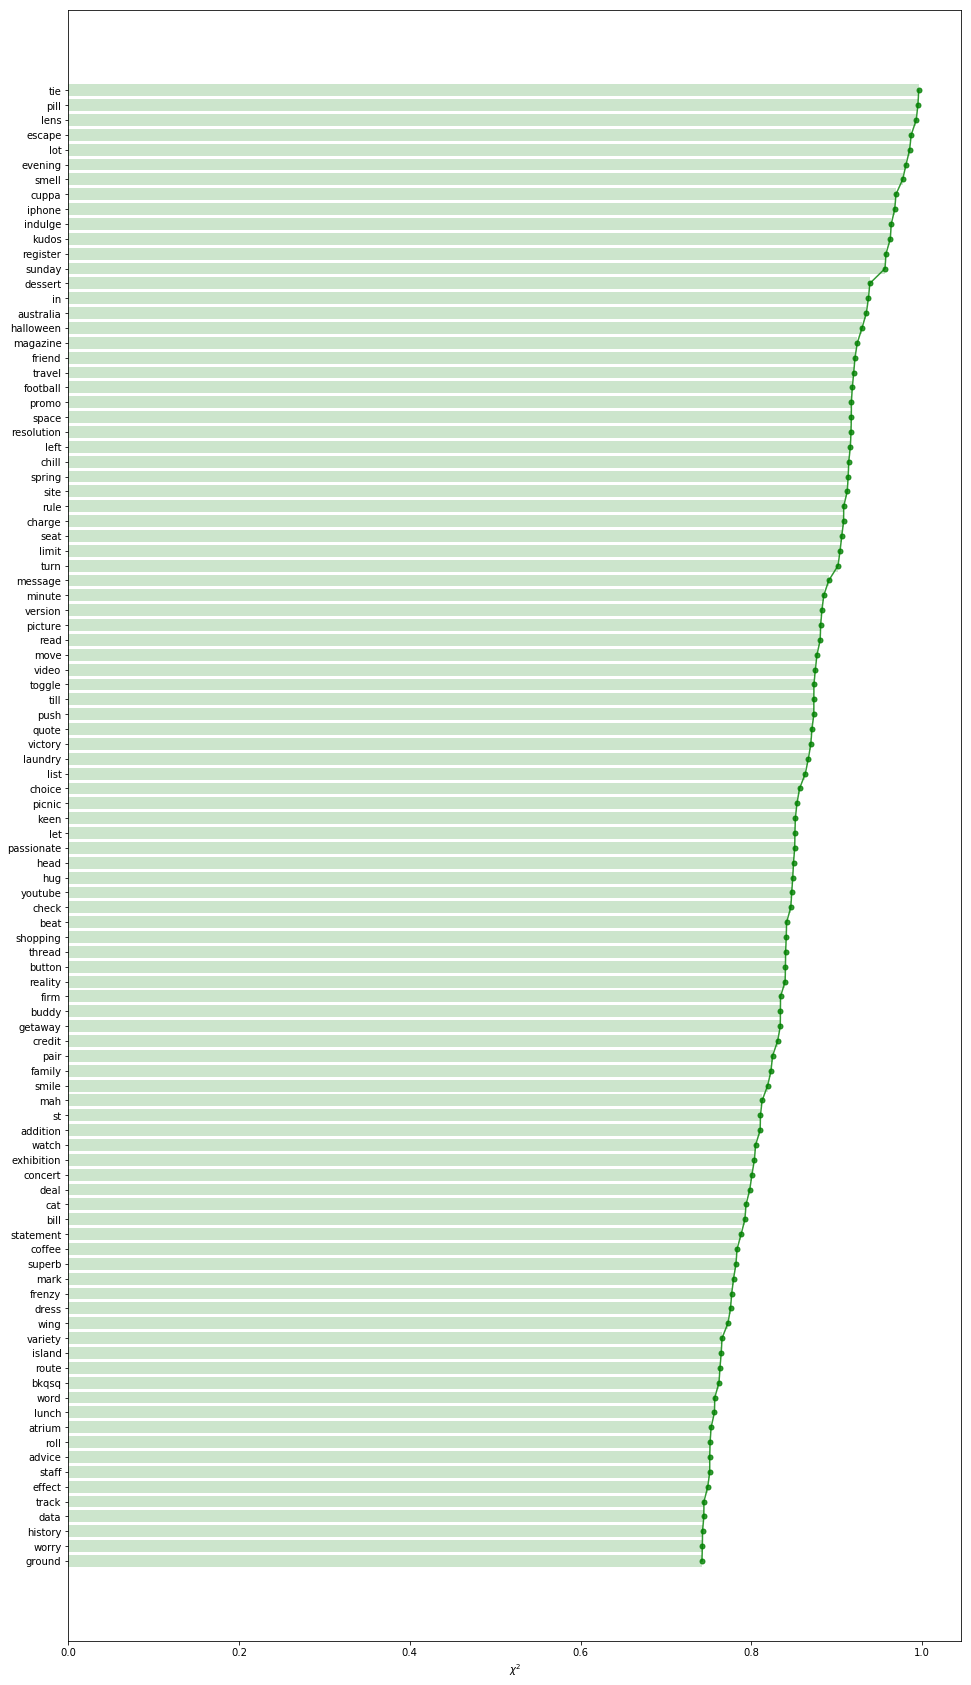

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,30))
wscores = list(zip(tfidf_vectorizer.get_feature_names(), chi2score))
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = list(zip(*wchi2[-100:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.barh(x,topchi2[1], align='center', alpha=0.2, color='g')
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8, color='g')
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show()

In [69]:
from sklearn.feature_selection import SelectKBest, chi2  
ch2 = SelectKBest(chi2, k=5000)  
chi_filter_training = ch2.fit_transform(X_tfidf_matrix,Y_train)  
chi_filter_training.shape

(11524, 5000)

## ML algorithms¶

In [70]:
# Train the algorithm
from sklearn.naive_bayes import MultinomialNB
NB_clf = MultinomialNB().fit(chi_filter_training, Y_train)

from sklearn import svm
#SVM_clf = svm.SVC().fit(X_train, Y_train)  

from sklearn.linear_model import LogisticRegression
#

from sklearn.linear_model import SGDClassifier
#SGD_clf = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, n_iter=5, random_state=42).fit(X_train, Y_train)  

## Test dataset 

In [71]:
from os import listdir
from os.path import isfile, join
#posi_test_path = '/Users/yyb/Documents/5920_Projects/followers_tweets_filter/positive_labeled_users'
#posi_test_files = [f for f in listdir(posi_test_path) if isfile(join(posi_test_path,f))]
posi_test_list=read_as_list('/Users/yyb/Documents/5920_Projects/followers_tweets_filter/positive_labeled_users/inc_asean.txt')
posi_test_list=strip_drop_duplicated(posi_test_list)
posi_test_list=remove_symbols(posi_test_list)
posi_test_list=standardize(posi_test_list)
posi_test_list=stop_word_removal(posi_test_list)
posi_test_list=lematization(posi_test_list)

posi_test_list=list_to_string(posi_test_list)

filepath='/Users/yyb/Documents/5920_Projects/followers_tweets_filter/positive_labeled_users/test_data_label.txt'
labeled_df = pd.read_csv(filepath, delimiter="^", header=None,error_bad_lines=False,engine='python')
labeled_df.columns = ['labels',"tweets", "time", "date"]
labeled_df.head()

,labels,tweets,time,date
0,T,Samsung Galaxy S6 line to receive Android 8.0 ...,2:35 PM,27 Nov 2017
1,T,Say hello to the future. iPhone X.,1:22 PM,12 Sep 2017
2,T,Download #mAadhaar from … on any android phon...,11:54 PM,18 Jul 2017
3,T,Jeff talking about the Semantic Boosting Algor...,9:08 PM,18 Jun 2014
4,T,#shameful #explainsalot Apple reduces speed of...,2:19 AM,20 Dec 2017


In [72]:
'''
#implement only when you change test dataset
labeled_tweets=list(labeled_df['tweets'])
for i in labeled_tweets:
    with open('/Users/yyb/Documents/5920_Projects/followers_tweets_filter/positive_labeled_users/test_data_only_tweets.txt','a') as txtfile:
        txtfile.write(i+'\n')
'''

"\n#implement only when you change test dataset\nlabeled_tweets=list(labeled_df['tweets'])\nfor i in labeled_tweets:\n    with open('/Users/yyb/Documents/5920_Projects/followers_tweets_filter/positive_labeled_users/test_data_only_tweets.txt','a') as txtfile:\n        txtfile.write(i+'\n')\n"

In [73]:

labeled_test=read_as_list('/Users/yyb/Documents/5920_Projects/followers_tweets_filter/positive_labeled_users/test_data_only_tweets.txt')
labeled_test=remove_symbols(labeled_test)
labeled_test=standardize(labeled_test)
labeled_test=stop_word_removal(labeled_test)
labeled_test=lematization(labeled_test)

# get the labels of the targets
X_test_target=np.array(labeled_df['labels'])

# define the test data
labeled_test=list_to_string(labeled_test)


## Evaluation

In [74]:
#X_test = tfidf_vectorizer.transform(X_test)
X_test = ch2.transform(tfidf_vectorizer.transform(labeled_test))

### Naive Bayes

In [75]:
predicted_NB =NB_clf.predict(X_test)
predicted_NB

array(['T', 'F', 'T', 'T', 'F', 'F', 'F', 'T', 'T', 'T', 'T', 'T', 'T',
       'F', 'T', 'F', 'F', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'F', 'T',
       'T', 'F', 'T', 'F', 'T', 'T', 'T', 'F', 'F', 'T', 'T', 'F', 'T',
       'T', 'F', 'T', 'F', 'F', 'T', 'F', 'F', 'T', 'T', 'T', 'T', 'T',
       'F', 'F', 'F', 'T', 'F', 'F', 'T', 'F', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'T', 'F', 'T', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'T', 'F', 'F', 'F', 'F',
       'F', 'F', 'T', 'F', 'F', 'F', 'F', 'F', 'F'], 
      dtype='<U1')

In [76]:
np.mean(predicted_NB == X_test_target)

0.72999999999999998

In [77]:
from sklearn.metrics import confusion_matrix
confusion_matrix(X_test_target, predicted_NB)

array([[42,  8],
       [19, 31]])

In [78]:
from sklearn.metrics import classification_report

target_names = ['F','T']
print(classification_report(X_test_target, predicted_NB, target_names=target_names))

             precision    recall  f1-score   support

          F       0.69      0.84      0.76        50
          T       0.79      0.62      0.70        50

avg / total       0.74      0.73      0.73       100



### SVM

In [38]:
predicted_SVM =SVM_clf.predict(X_test)
predicted_SVM

array(['F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'F', 'F', 'F'], 
      dtype='<U1')

In [46]:
np.mean(predicted_SVM == X_test_target)

0.44444444444444442

In [47]:
from sklearn.metrics import confusion_matrix
confusion_matrix(X_test_target, predicted_SVM)

array([[20,  0],
       [25,  0]])

In [48]:
from sklearn.metrics import classification_report

target_names = ['F','T']
print(classification_report(X_test_target, predicted_SVM, target_names=target_names))

             precision    recall  f1-score   support

          F       0.44      1.00      0.62        20
          T       0.00      0.00      0.00        25

avg / total       0.20      0.44      0.27        45



/Users/yyb/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### SGD

In [49]:
predicted_SGD =SGD_clf.predict(X_test)
predicted_SGD

array(['T', 'F', 'F', 'T', 'F', 'F', 'F', 'T', 'T', 'T', 'F', 'F', 'T',
       'F', 'F', 'F', 'F', 'F', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'F',
       'F', 'F', 'F', 'F', 'F', 'T', 'F', 'F', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'F', 'F', 'T'], 
      dtype='<U1')

In [50]:
np.mean(predicted_SGD == X_test_target)

0.66666666666666663

In [52]:
from sklearn.metrics import confusion_matrix
confusion_matrix(X_test_target, predicted_SGD)

array([[18,  2],
       [13, 12]])

In [53]:
from sklearn.metrics import classification_report

target_names = ['F','T']
print(classification_report(X_test_target, predicted_SGD, target_names=target_names))

             precision    recall  f1-score   support

          F       0.58      0.90      0.71        20
          T       0.86      0.48      0.62        25

avg / total       0.73      0.67      0.66        45



In [171]:
from sklearn.naive_bayes import MultinomialNB  
from sklearn.cross_validation import train_test_split   
from sklearn.cross_validation import StratifiedKFold  
from sklearn.cross_validation import KFold  
from sklearn.metrics import precision_recall_curve    
from sklearn.metrics import classification_report 


X = chi_filter_training 
y = np.array(Y_train)
skf = StratifiedKFold(y,n_folds=10)  
y_pre = y.copy()  
for train_index,test_index in skf:  
    x_train= X[train_index]
    x_test = X[test_index]  
    y_train= y[train_index]
    y_test = y[test_index]  
    clf = MultinomialNB().fit(X_train, y_train)    
    y_pre[test_index] = clf.predict(X_test)    
         
print('Accuracy %.6f' %(np.mean(y_pre == y)))



/Users/yyb/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: Found input variables with inconsistent numbers of samples: [1, 10232]

https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))


#dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
#documents = dataset.data
#documents = str_posi_list
documents = new_nega_list

In [65]:
no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

no_topics = 6

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=50, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

no_top_words = 10
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
student game family school man city baby programme dinner song
Topic 1:
time home week school friend kid food experience child team
Topic 2:
day singapore people today fan teacher act sea love woman
Topic 3:
life world dn stay chance hotel music samsung video galaxy
Topic 4:
pm pop nov art tweet fear bag artist month buffet
Topic 5:
year child fav weekend share thing parent tip voucher mtv


In [64]:
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
year month idea life friend school jail nov home treatment
Topic 1:
day today weekend family week birthday valentine kid world teacher
Topic 2:
student school child share programme teacher sec parent pri skill
Topic 3:
time tonight people parent moment drama step friend thought relationship
Topic 4:
pm nov artist oct tweet fan ceremony fear song catch


# https://www.youtube.com/watch?v=FheTDyCwRdE
A good video about the theory behind smote

SMOTE
http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.over_sampling.SMOTE.html
ADASYN
http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.over_sampling.ADASYN.html#imblearn.over_sampling.ADASYN
7 Techniques to Handle Imbalanced Data
https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html
SMOTE: Synthetic Minority Over-sampling Technique
https://www.cs.cmu.edu/afs/cs/project/jair/pub/volume16/chawla02a-html/chawla2002.html
over and under sampling wiki
https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#cite_note-2

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE

In [2]:
print(__doc__)


def plot_resampling(ax, X, y, title):
    c0 = ax.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5)
    c1 = ax.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5)
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([-6, 8])
    ax.set_ylim([-6, 6])

    return c0, c1

Automatically created module for IPython interactive environment


In [3]:
# Generate the dataset
X, y = make_classification(n_classes=2, class_sep=2, weights=[0.3, 0.7],
                           n_informative=3, n_redundant=1, flip_y=0,
                           n_features=20, n_clusters_per_class=1,
                           n_samples=80, random_state=10)

In [10]:
type(X)

numpy.ndarray

In [4]:
# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components=2)

# Fit and transform x to visualise inside a 2D feature space
X_vis = pca.fit_transform(X)

In [5]:
# Apply regular SMOTE
kind = ['regular', 'borderline1', 'borderline2', 'svm']
sm = [SMOTE(kind=k) for k in kind]
X_resampled = []
y_resampled = []
X_res_vis = []
for method in sm:
    X_res, y_res = method.fit_sample(X, y)
    X_resampled.append(X_res)
    y_resampled.append(y_res)
    X_res_vis.append(pca.transform(X_res))

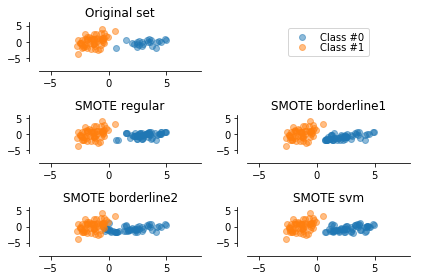

In [6]:
# Two subplots, unpack the axes array immediately
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
# Remove axis for second plot
ax2.axis('off')
ax_res = [ax3, ax4, ax5, ax6]

c0, c1 = plot_resampling(ax1, X_vis, y, 'Original set')
for i in range(len(kind)):
    plot_resampling(ax_res[i], X_res_vis[i], y_resampled[i],
                    'SMOTE {}'.format(kind[i]))

ax2.legend((c0, c1), ('Class #0', 'Class #1'), loc='center',
           ncol=1, labelspacing=0.)
plt.tight_layout()
plt.show()

In [17]:
X_tfidf_matrix

<16622x6324 sparse matrix of type '<class 'numpy.float64'>'
	with 63273 stored elements in Compressed Sparse Row format>

In [25]:
X_tfidf_matrix

<16622x6324 sparse matrix of type '<class 'numpy.float64'>'
	with 63273 stored elements in Compressed Sparse Row format>

In [26]:
Y_train

['T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T',
 'T'

## Resampling

SMOTE
http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.over_sampling.SMOTE.html

In [ ]:
X, y = make_classification(n_classes=2, class_sep=2,weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
print('Original dataset shape {}'.format(Counter(y)))
#Original dataset shape Counter({1: 900, 0: 100})

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))
#Resampled dataset shape Counter({0: 900, 1: 900})



## Ensemble Learning

In [42]:
#https://machinelearningmastery.com/ensemble-machine-learning-algorithms-python-scikit-learn/

import pandas
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
cart = DecisionTreeClassifier()
num_trees = 100
model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, X_tfidf_matrix, Y_train, cv=kfold)
print(results.mean())

0.892839951865


In [31]:
#bagging NB
from sklearn.naive_bayes import MultinomialNB
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier

seed = 9
kfold = model_selection.KFold(n_splits=10, random_state=seed)
cart = MultinomialNB()

model = BaggingClassifier(base_estimator=cart, random_state=seed)
results = model_selection.cross_val_score(model, X_tfidf_matrix, Y_train, cv=kfold)
print(results.mean())

0.88182912154


In [34]:
#boosting NB
from sklearn.naive_bayes import MultinomialNB
from sklearn import model_selection
from sklearn.ensemble import AdaBoostClassifier

seed = 9
kfold = model_selection.KFold(n_splits=10, random_state=seed)
cart = MultinomialNB()

model = AdaBoostClassifier(base_estimator=cart, random_state=seed)
results = model_selection.cross_val_score(model, X_tfidf_matrix, Y_train, cv=kfold)
print(results.mean())

0.653309265945


In [43]:
#Stochastic Gradient Boosting
from sklearn.naive_bayes import MultinomialNB
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingClassifier

seed = 7
num_trees = 100
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = GradientBoostingClassifier(n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, X_tfidf_matrix, Y_train, cv=kfold)
print(results.mean())

0.72797888206


In [41]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)

# create the sub models
estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = DecisionTreeClassifier()
estimators.append(('cart', model2))
model3 = SVC()
estimators.append(('svm', model3))

# create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, X_tfidf_matrix, Y_train, cv=kfold)
print(results.mean())

0.873345367028
